# Import libraries

In [23]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt  
import cv2  
import os 
import glob as gb 
from tqdm.auto import tqdm

import tensorflow as tf 
from tensorflow import keras 
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Conv2D , MaxPooling2D , SeparableConv2D , BatchNormalization , Conv2DTranspose , UpSampling2D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import Precision, Recall

# Loading dataset 

In [2]:
img_size = 224

In [3]:
class CustomData : 
    def __init__(self , images_dir , masks_dir) : 
        self.image_path = list(gb.glob(os.path.join(images_dir, '*'))) 
        self.mask_path = list(gb.glob(os.path.join(masks_dir, '*')))
        
    def data_size(self) : 
        return len(self.image_path)
    
    
    def getimage(self) : 
        images = [] 
        image_paths = self.image_path 
        
        for path in tqdm(image_paths) : 
            
            img = cv2.imread(str(path)) 
            img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
            img = cv2.resize(img , (img_size , img_size)) 
            img = img/255 
            images.append(img) 
            
        images = np.array(images)
        return images
        
    
    def getmask(self) : 
        masks = [] 
        
        mask_paths = self.mask_path 
        
        for path in tqdm(mask_paths) : 
            mask = cv2.imread(str(path) , 0) 
#             mask = cv2.cvtColor(mask , cv2.COLOR_BGR2RGB)
            mask = cv2.resize(mask , (img_size , img_size)) 
            mask = mask/255 
            masks.append(mask)
            
        masks = np.array(masks)
        return masks

In [4]:
train_images_dir = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images"
train_masks_dir = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/masks"

In [5]:
train_set = CustomData(train_images_dir , train_masks_dir)

In [6]:
train_set.data_size()

6012

In [7]:
train_images = train_set.getimage()
train_masks = train_set.getmask()

  0%|          | 0/6012 [00:00<?, ?it/s]

  0%|          | 0/6012 [00:00<?, ?it/s]

In [8]:
train_images.shape , train_masks.shape

((6012, 224, 224, 3), (6012, 224, 224))

In [9]:
test_images_dir = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images"
test_masks_dir = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/masks"

In [10]:
test_set = CustomData(test_images_dir , test_masks_dir)

In [11]:
test_set.data_size()

3616

In [12]:
test_images = test_set.getimage()
test_masks = test_set.getmask()

  0%|          | 0/3616 [00:00<?, ?it/s]

  0%|          | 0/3616 [00:00<?, ?it/s]

In [13]:
test_images.shape , test_masks.shape

((3616, 224, 224, 3), (3616, 224, 224))

In [14]:
def plot_samples(images, titles):
    fig, axs = plt.subplots(3, 8, figsize=(16, 8))
    axs = axs.flatten()

    for i in range(24):
        axs[i].imshow(images[i])
        axs[i].axis('off')
        axs[i].set_title(titles[i])
        

    plt.tight_layout()
    plt.show()

# Samples of images of people with Lung_Opacity

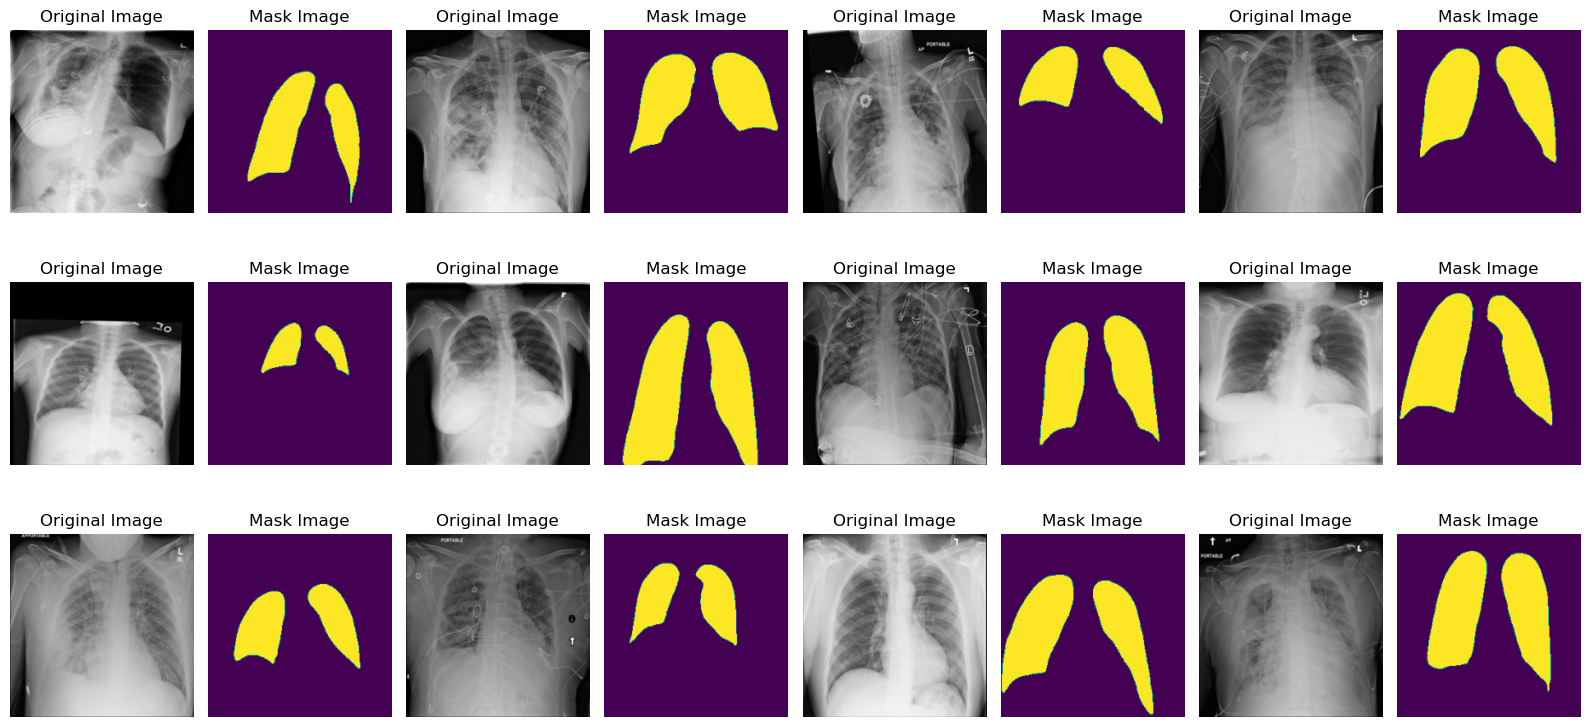

In [15]:
random_indices = np.random.randint(0, len(train_images), 24)

random_images = []
titles = []

for i, index in enumerate(random_indices):
    if i % 2 == 0:
        random_images.append(train_images[index])
        titles.append("Original Image")
    else:
        random_images.append(train_masks[index])
        titles.append("Mask Image")

plot_samples(random_images, titles)

# Samples of images of people with COVID-19

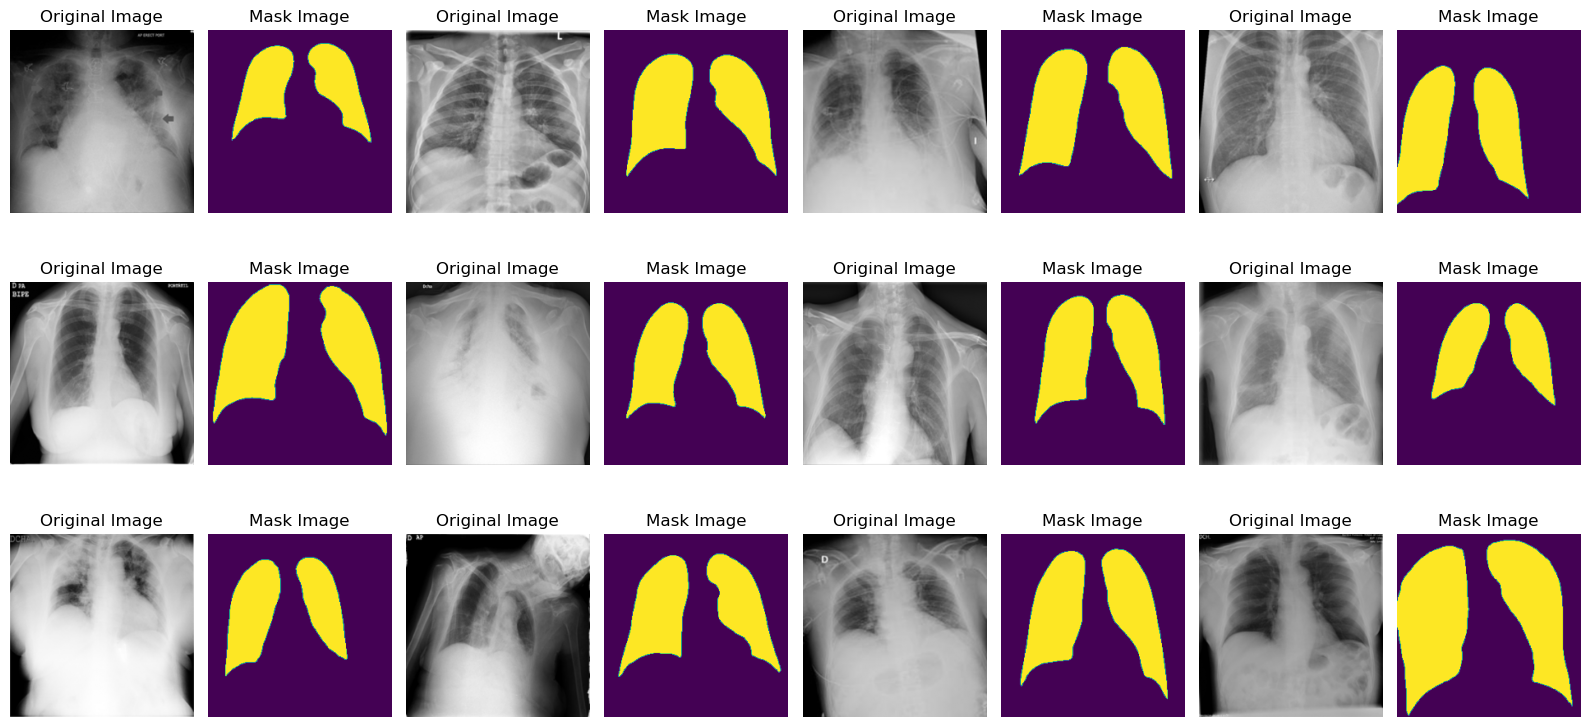

In [16]:
random_indices = np.random.randint(0, len(test_images), 24)

random_images = []
titles = []

for i, index in enumerate(random_indices):
    if i % 2 == 0:
        random_images.append(test_images[index])
        titles.append("Original Image")
    else:
        random_images.append(test_masks[index])
        titles.append("Mask Image")

plot_samples(random_images, titles)

# Build the model 

In [17]:
def UNET(in_channels , out_channels) : 
    inputs = keras.Input(shape=in_channels + (3,))
    
    x = Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    PreviousBlock = x
    
    # encoding 
    for filters in [64, 128, 256 , 512]:
        x = layers.Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = SeparableConv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        residual = Conv2D(filters, 1, strides=2, padding="same")(
            PreviousBlock
        )
        x = layers.add([x, residual])
        PreviousBlock = x 
        
        
    # decoding 
    
    for filters in [512, 256 , 128 , 64 , 32] : 
        
        x = layers.Activation("relu")(x) 
        x = Conv2DTranspose(filters , 3 , padding = "same")(x)
        x= BatchNormalization()(x) 
        
        x = layers.Activation("relu")(x) 
        x = Conv2DTranspose(filters , 3 , padding = "same")(x)
        x= BatchNormalization()(x)
        
        x = UpSampling2D(2)(x)
        
        res = UpSampling2D(2)(PreviousBlock)
        
        res = Conv2D(filters , 1 , padding = "same")(res)
        
        x = layers.add([x , res])
        
        PreviousBlock = x
        
        
    outputs = Conv2D(out_channels , 3 , activation = "sigmoid" , padding = "same")(x)
    
    model = Model(inputs , outputs)
    
    return model 

In [18]:
keras.backend.clear_session()

In [19]:
model = UNET(in_channels=(224, 224), out_channels=1)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

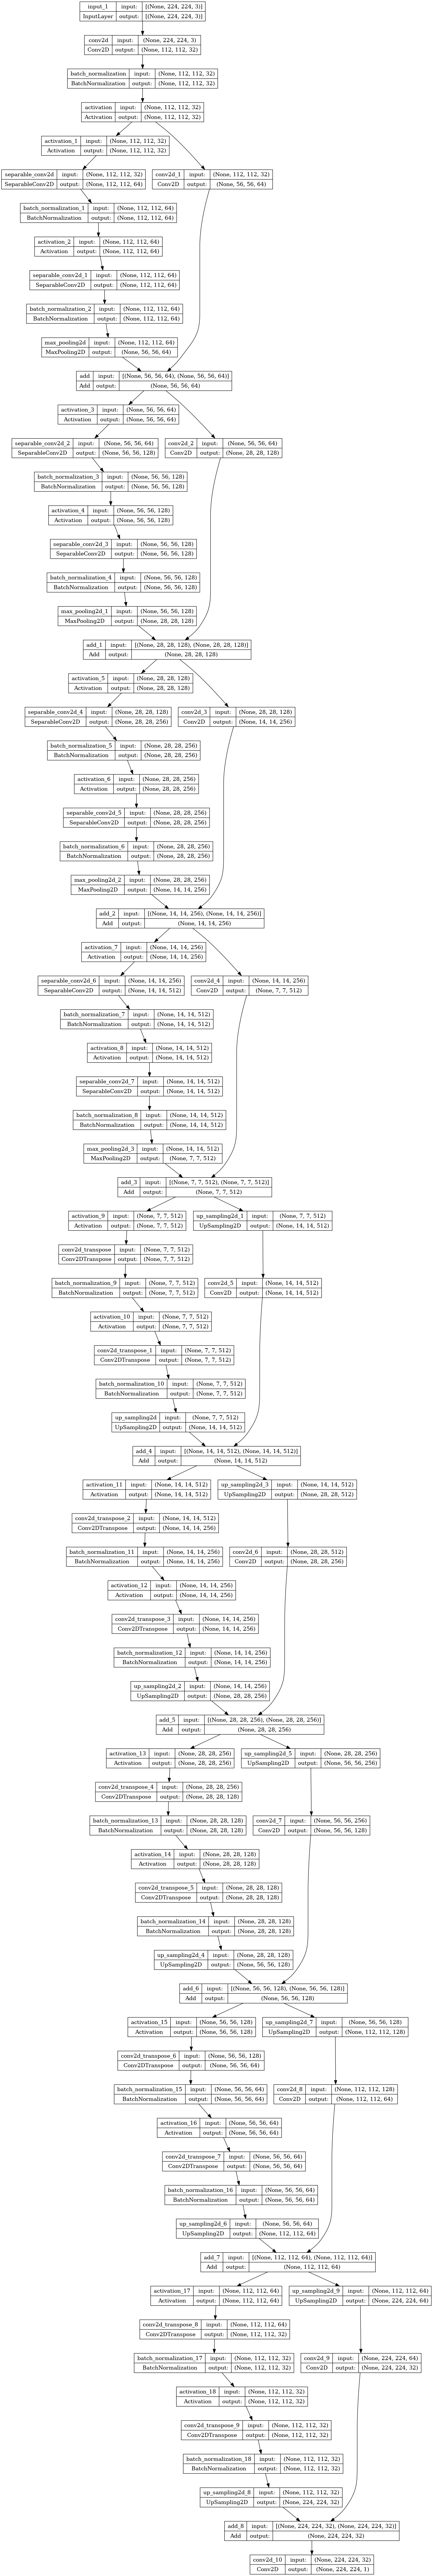

In [21]:
keras.utils.plot_model(model, show_shapes=True)

# Train our model

In [24]:
model.compile(Adam(0.001) , BinaryCrossentropy(), metrics=['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])

In [26]:
epochs = 10
BATCH_SIZE = 8

In [27]:
history = model.fit(train_images , train_masks , batch_size = BATCH_SIZE , epochs = epochs  )

Epoch 1/10
752/752 [==============================] - 1997s 3s/step - loss: 0.1303 - accuracy: 0.9447 - precision: 0.9143 - recall: 0.8613
Epoch 2/10
752/752 [==============================] - 1972s 3s/step - loss: 0.0522 - accuracy: 0.9699 - precision: 0.9662 - recall: 0.9283
Epoch 3/10
752/752 [==============================] - 1981s 3s/step - loss: 0.0413 - accuracy: 0.9742 - precision: 0.9751 - recall: 0.9395
Epoch 4/10
752/752 [==============================] - 1983s 3s/step - loss: 0.0367 - accuracy: 0.9760 - precision: 0.9790 - recall: 0.9439
Epoch 5/10
752/752 [==============================] - 1977s 3s/step - loss: 0.0344 - accuracy: 0.9769 - precision: 0.9808 - recall: 0.9463
Epoch 6/10
752/752 [==============================] - 1984s 3s/step - loss: 0.0326 - accuracy: 0.9777 - precision: 0.9825 - recall: 0.9481
Epoch 7/10
752/752 [==============================] - 1981s 3s/step - loss: 0.0316 - accuracy: 0.9780 - precision: 0.9832 - recall: 0.9490
Epoch 8/10
752/752 [=======

In [39]:
f1_score = (2 * history.history['precision'][-1] * history.history['recall'][-1]) / (history.history['precision'][-1] + history.history['recall'][-1])

In [45]:
print(f"The loss of the training set is : {history.history['loss'][-1]:0.2f}\n")
print(f"The accuracy of the training set is : {((history.history['accuracy'][-1]) * 100):0.2f}%\n")
print(f"The precision of the training set is : {history.history['precision'][-1]:0.3f}\n")
print(f"The recall of the training set is : {history.history['recall'][-1]:0.3f}\n")
print(f"The F1 score of the training set is : {f1_score:0.4f}\n")

The loss of the training set is : 0.03

The accuracy of the training set is : 97.97%

The precision of the training set is : 0.987

The recall of the training set is : 0.953

The F1 score of the training set is : 0.9698



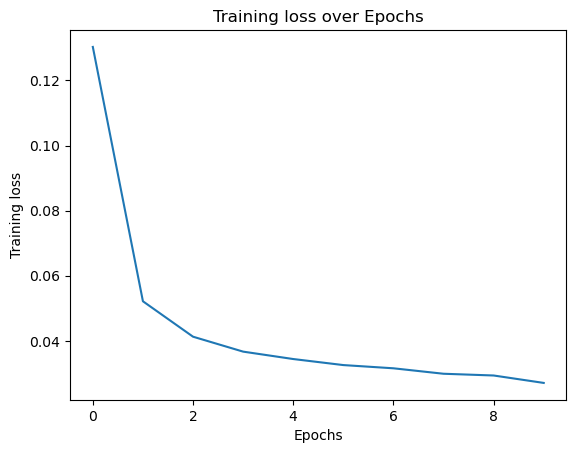

In [29]:
plt.plot(history.epoch, history.history['loss'])
plt.title('Training loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.show()

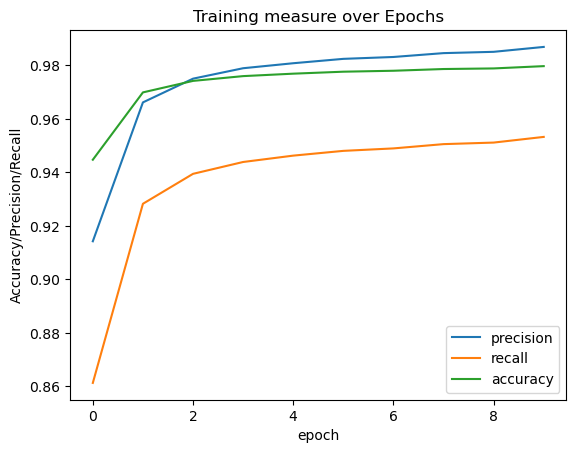

In [31]:
plt.plot(history.history['precision'], label='precision')

plt.plot(history.history['recall'], label='recall')

plt.plot(history.history['accuracy'], label='accuracy')

plt.title('Training measure over Epochs')
plt.xlabel('epoch')
plt.ylabel('Accuracy/Precision/Recall')
plt.legend()
plt.show()

# Model Evaluation

In [46]:
test_loss , test_acc , test_precision , test_recall = model.evaluate(test_images , test_masks)

113/113 [==============================] - 423s 4s/step - loss: 0.0530 - accuracy: 0.9722 - precision: 0.9883 - recall: 0.9272


In [47]:
test_f1score = (2 * test_precision * test_recall) / (test_precision + test_recall)

In [51]:
print(f"The loss of the testing set is : {test_loss:0.2f}\n")
print(f"The accuracy of the testing set is : {(test_acc * 100):0.2f}%\n")
print(f"The precision of the testing set is : {test_precision:0.3f}\n")
print(f"The recall of the testing set is : {test_recall:0.3f}\n")
print(f"The F1 score of the testing set is : {test_f1score:0.4f}\n")

The loss of the testing set is : 0.05

The accuracy of the testing set is : 97.22%

The precision of the testing set is : 0.988

The recall of the testing set is : 0.927

The F1 score of the testing set is : 0.9568



In [52]:
y_preds = model.predict(test_images)

113/113 [==============================] - 442s 4s/step


In [81]:
def draw(test_images , test_masks , y_preds):
    
    plt.figure(figsize = (20, 10))
    index = 0
    n = np.random.randint(y_preds.shape[0])
    for i in range(18):
        plt.subplot(3, 6, (i + 1))
        if index == 0:
            plt.imshow(test_images[n])
            plt.imshow(test_images[n])
            plt.title('Original Image')
            index = 1
            plt.axis('off')
        elif index == 1:
            plt.imshow(test_masks[n])
            plt.imshow(test_masks[n], alpha = 0.2, cmap = 'jet')
            plt.title('Original Mask')
            index = 2
            plt.axis('off')
        elif index == 2 : 
            plt.imshow(test_masks[n])
            plt.imshow(y_preds[n], alpha = 0.2, cmap = 'jet')
            plt.title('Predict Mask')
            index = 0
            n = np.random.randint(y_preds.shape[0])
            plt.axis('off')
        
            
    plt.legend()

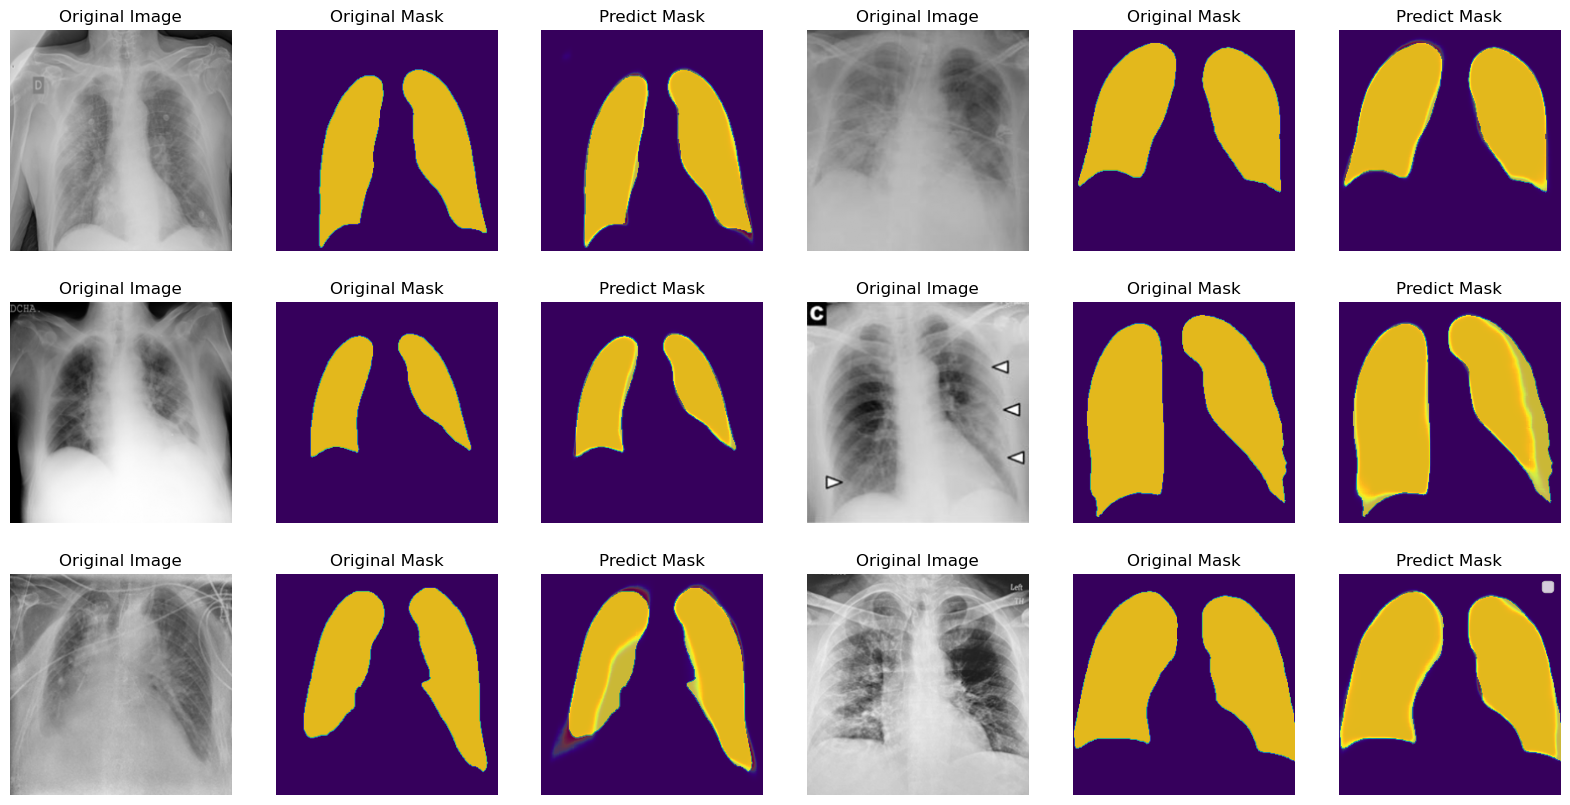

In [83]:
draw(test_images, test_masks , y_preds)

In [84]:
model.save("COVID-19 Radiography.h5")